# Support Vector Machine (SVM)
SVM (Support Vector Machine) เป็นอัลกอริทึมการเรียนรู้ของเครื่องจักรที่ใช้ในงานการจำแนกแบบ Supervised Learning ที่มีความเป็นที่นิยมอย่างมากในการแก้ปัญหาที่มีความซับซ้อน และสามารถใช้กับข้อมูลที่มีการแบ่งกลุ่มเป็นชั้น (class) ได้เป็นอย่างดี

SVM มีแนวคิดหลักที่จะสร้างเส้นแบ่ง (hyperplane) ระหว่างกลุ่มข้อมูลที่แตกต่างกันในข้อมูลแนวเดียวกัน โดยทำการเลือกเส้นแบ่งที่มีระยะห่างระหว่างจุดข้อมูลใกล้ที่สุดในแต่ละกลุ่มมากที่สุด (support vectors) โดย SVM จะพยายามหาเส้นแบ่งที่มีระยะห่างระหว่างกลุ่มข้อมูลสูงสุด เพื่อให้มีประสิทธิภาพในการทำนายคลาสของข้อมูลใหม่

นอกจากเส้นแบ่งแบบเชิงเส้น (linear) SVM ยังสามารถใช้เส้นแบ่งแบบเชิงเส้นที่เคลื่อนที่ (moving boundary) ได้ โดยใช้เทคนิคที่เรียกว่า kernel trick ที่สามารถแปลงปัญหาที่ไม่เชิงเส้นให้กลายเป็นปัญหาที่เชิงเส้นได้ ทำให้ SVM สามารถใช้กับข้อมูลที่มีความซับซ้อนและไม่เป็นเชิงเส้นได้

SVM มีหลักการทำงานแบ่งออกเป็นหลายขั้นตอน:
1. การเลือกเครื่องหมายตัวแบ่ง (margin): SVM จะค้นหาเส้นแบ่งที่มีระยะห่างระหว่างจุดข้อมูลใกล้ที่สุดในแต่ละกลุ่ม (support vectors) มากที่สุด โดยกำหนดเครื่องหมายตัวแบ่งเป็นเส้นในระหว่างกลุ่มข้อมูล

2. การปรับแต่ง (regularization): SVM ใช้เทคนิค regularization เพื่อควบคุมความซับซ้อนของโมเดล และลดโอกาสการเกิด overfitting โดยการกำหนดค่า C ที่เป็นพารามิเตอร์ของ regularization ซึ่งสัมพันธ์กับความคลาดเคลื่อนของเครื่องหมายตัวแบ่งและจำนวนข้อมูลที่ถูกจัดอยู่ในช่วงของเครื่องหมายตัวแบ่ง

3. การใช้ kernel trick: SVM สามารถใช้ kernel trick เพื่อแปลงข้อมูลให้เข้ากับเส้นแบ่งแบบเชิงเส้นได้ ซึ่ง kernel trick เป็นการใช้ฟังก์ชันหนึ่ง (เช่น linear, polynomial, radial basis function) เพื่อเปลี่ยนข้อมูลให้อยู่ในเชิงเส้น และจากนั้นใช้ SVM กับข้อมูลใหม่ที่เป็นเชิงเส้น

SVM เป็นอัลกอริทึมที่มีประสิทธิภาพในการจัดกลุ่มและความสามารถในการทำนายที่ดี และสามารถนำมาใช้กับการจำแนกข้อมูลในหลายๆ งาน เช่น การจำแนกภาพ, การตรวจจับวัตถุ, การจำแนกอีเมล์สแปม เป็นต้น

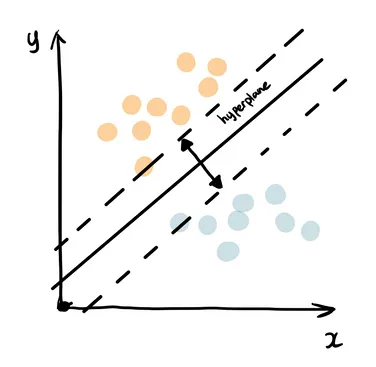
SVM [ที่มา](https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501)

*Hyperplane*

สมการที่สำคัญใน Support Vector Machines (SVM) เป็นสมการของ hyperplane ที่ใช้ในการแบ่งกลุ่มข้อมูลอย่างมีประสิทธิภาพ

ใน SVM, เราสนใจค้นหา hyperplane ที่แบ่งกลุ่มข้อมูลอย่างชัดเจน โดยใช้ข้อมูลในกลุ่มที่อยู่ใกล้สนามรบของ hyperplane ได้มากที่สุด (support vectors) เพื่อให้มีความห่างระหว่างกลุ่มข้อมูลสองกลุ่มมากที่สุด

สมการของ hyperplane ใน SVM สามารถเขียนได้ในรูปแบบดังนี้:

\begin{align}
\mathbf{w} \cdot \mathbf{x} + b = 0
\end{align}

ในสมการนี้:
- $\mathbf{w}$ เป็นเวกเตอร์ตั้งฉากกับ hyperplane
- $\mathbf{x}$ เป็นเวกเตอร์ของตัวอย่างข้อมูล
- $b$ เป็นค่าไบแอส (bias) หรือระยะห่างของ hyperplane จากจุดเริ่มต้นของระบบพิกัด

Hyperplane จะแบ่งกลุ่มข้อมูลอย่างชัดเจนโดยให้ตัวอย่างข้อมูลที่อยู่ในข้างเดียวกับ $\mathbf{w} \cdot \mathbf{x} + b$ มีค่ามากกว่า 0 และตัวอย่างข้อมูลที่อยู่ในข้างตรงข้ามกับ $\mathbf{w} \cdot \mathbf{x} + b$ มีค่าน้อยกว่า 0

Hyperplane ที่มีระยะห่างน้อยที่สุดจากตัวอย่างข้อมูลในกลุ่มสองกลุ่ม จะเรียกว่า Maximum Margin Hyperplane (MMH) และเวกเตอร์ $\mathbf{w}$ จะเป็นแนวทางของการค้นหา MMH

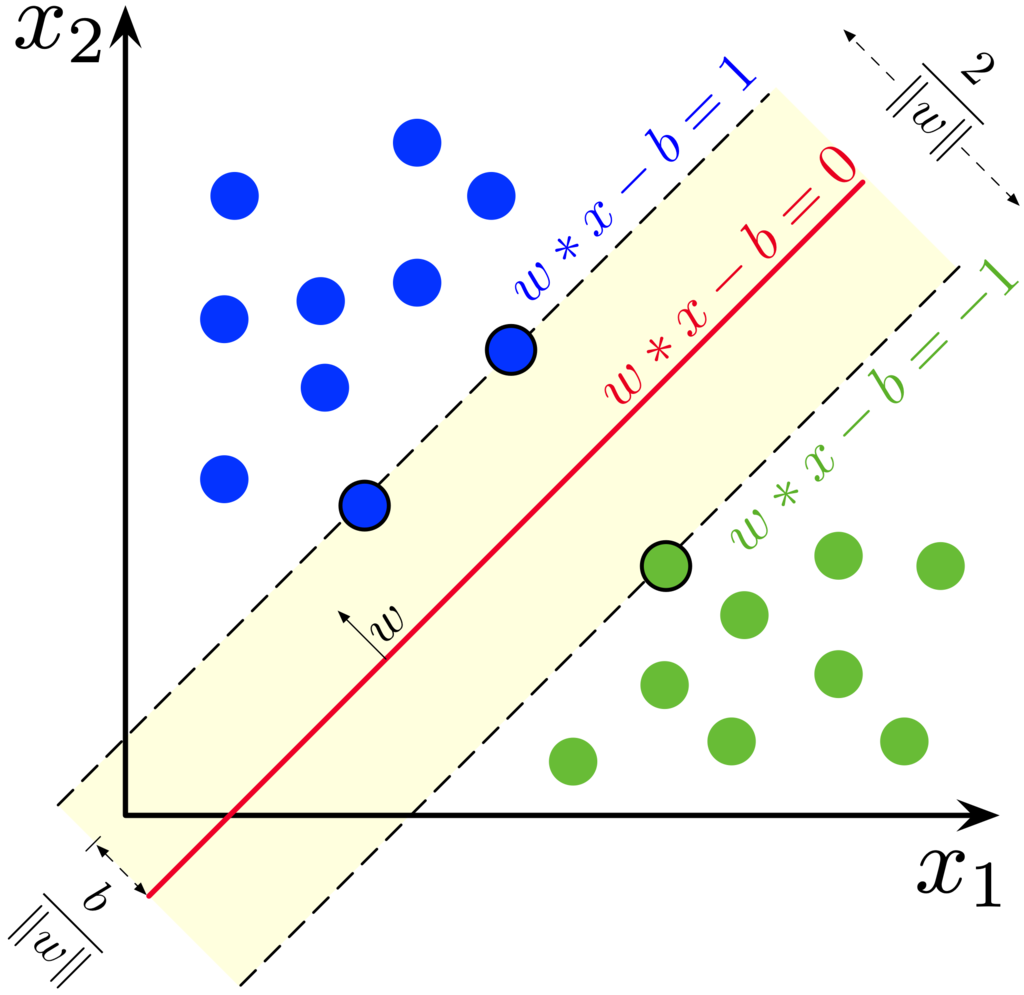
SVM and hyperplane ที่มา: wikipedia.com

อีกหนึ่งประเด็นสำคัญใน SVM คือการใช้ kernel function เพื่อแปลงชุดข้อมูลเชิงเส้นเป็นชุดข้อมูลที่ไม่เชิงเส้น เพื่อให้สามารถแบ่งกลุ่มข้อมูลที่ไม่เชิงเส้นได้ 
ฟังก์ชัน kernel ที่ใช้บ่อยคือเคอร์เนลเริ่มต้น (linear kernel), เคอร์เนลแบบหลายเหลี่ยม (polynomial kernel), เคอร์เนลเรดิอัลเบส (radial basis function, RBF) kernel ฯลฯ

*Hyperplane* คือแผนที่มิติสูงสุด (dimensionality-maximal) ที่ใช้ในการแบ่งกลุ่มข้อมูลใน SVM ในกรณีของ SVM แบบไลน์ (linear SVM) จะเป็นเส้นตรงหรือพื้นที่ที่แบ่งกลุ่มข้อมูลได้สองกลุ่ม ในรูปแบบที่ซับซ้อนขึ้น เช่น SVM แบบไม่เชิงเส้น (non-linear SVM) จะเป็นพื้นที่หรือผิวของตัวแบ่งกลุ่มใน SVM มีความสำคัญอย่างมากในการแบ่งกลุ่มข้อมูลอย่างมีประสิทธิภาพ และมีการปรับค่า hyperparameter C จะกำหนดความเข้มข้นของการปรับให้มีการผิดพลาดของตัวอย่างข้อมูล ซึ่ง C มีหน้าที่ควบคุมการแจกแจงของ hyperplane และ support vectors โดยเพิ่มหรือลดค่า C จะมีผลต่อความตึงเครียดของ SVM ซึ่งมีค่า C มากจะเน้นความถูกต้องในการแบ่งกลุ่มข้อมูลและมีค่า C น้อยจะให้ความสำคัญกับตัวอย่างข้อมูลที่อยู่ใกล้กับ hyperplane มากขึ้น

*Kernel*: Kernel เป็นฟังก์ชันที่ใช้ใน SVM เพื่อแปลงข้อมูลเชิงเส้นเป็นข้อมูลที่ไม่เชิงเส้นในเรื่องของการแบ่งกลุ่ม SVM ใช้ kernel function เพื่อเลือกเส้นตรงหรือพื้นที่ที่เหมาะสมในการแบ่งกลุ่มข้อมูลที่ไม่สามารถแบ่งได้ด้วยเส้นตรงเชิงเส้น เช่น Polynomial Kernel และ Radial Basis Function (RBF) Kernel เป็นต้น



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

# Generate simulated dataset
Generate simulated 2-class data for binary classification with 2 features

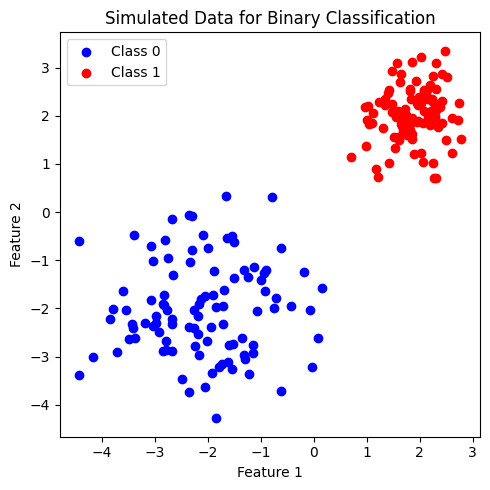

In [2]:
def generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
    np.random.seed(RANDOM_SEED)

    # กำหนด จำนวน features
    n_features = 2
    
    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[1,1], [0.5,0.5]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

# SVM 

A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.

Plot the maximum margin separating hyperplane within a two-class separable dataset using a Support Vector Machine classifier with linear kernel.

The figure below shows the decision function for a linearly separable problem, with 2 samples on the margin boundaries, called “support vectors”:

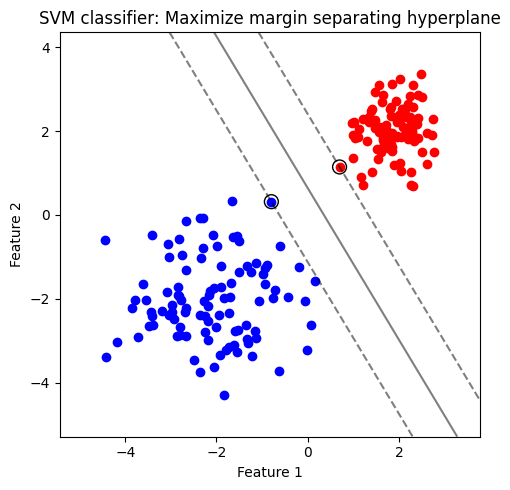

In [3]:
# สร้างโมเดล
clf = SVC(kernel='linear', random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot ข้อมูล x, y
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 0')

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf, 
                                       x, 
                                       plot_method="contour", 
                                       colors="k", levels=[-1, 0, 1], 
                                       alpha=0.5, linestyles=["--", "-", "--"],ax=ax,
                                       )
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0],
           clf.support_vectors_[:, 1],
           s=100, linewidth=1,
           facecolors='none',
           edgecolors='k'
           )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM classifier: Maximize margin separating hyperplane')
plt.tight_layout()
plt.show()

## SVM with different kernel

Figure below show plot the decision surface for four SVM classifiers with different kernels.

Linear kernel models have linear decision boundaries (intersecting hyperplanes) while the non-linear kernel models (polynomial or Gaussian RBF) have more flexible non-linear decision boundaries with shapes that depend on the kind of kernel and its parameters.

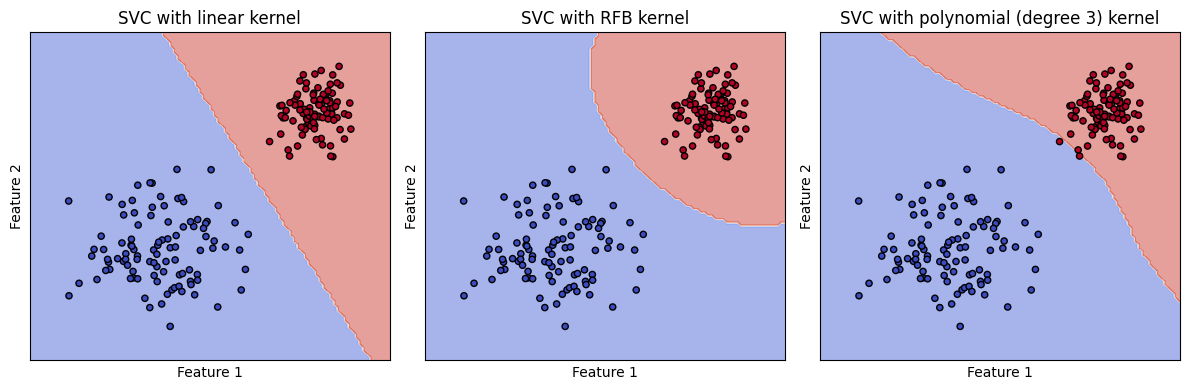

In [4]:
# สร้างชุดโมเดล
models = (SVC(kernel='linear', random_state=RANDOM_SEED),
          SVC(kernel='rbf', random_state=RANDOM_SEED),
          SVC(kernel='poly', degree=3, random_state=RANDOM_SEED),
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['SVC with linear kernel',
          'SVC with RFB kernel',
          'SVC with polynomial (degree 3) kernel',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

## SVM with varying 'C'

Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

(more info [Scaling the regularization parameter for SVCs](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html))

We will demonstrate the effect of 'C' on accuracy score

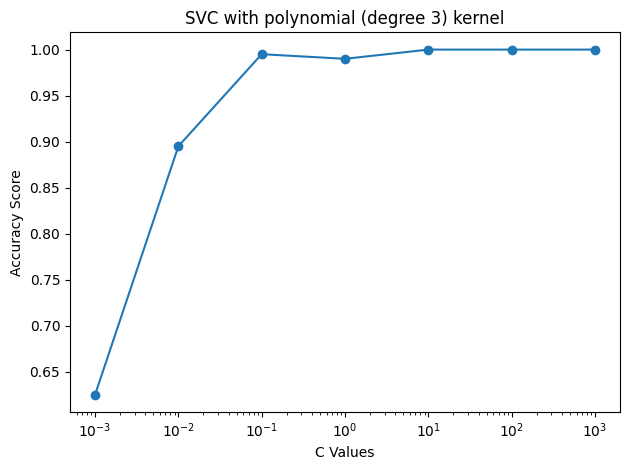

In [5]:
# กำหนดช่วงค่า C 
C_values = [0.001,0.01,0.1,1,10,100,1000]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
for C_val in C_values:
    clf = SVC(kernel='poly', degree=3, random_state=RANDOM_SEED, C=C_val)
    clf.fit(x, y)

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)
    
    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
plt.plot(C_values, accuracy, marker='o')
plt.xscale('log')
plt.xlabel('C Values')
plt.ylabel('Accuracy Score')
plt.title('SVC with polynomial (degree 3) kernel')
plt.tight_layout()
plt.show()

## SVC pipeline

### Generate 3-class dataset

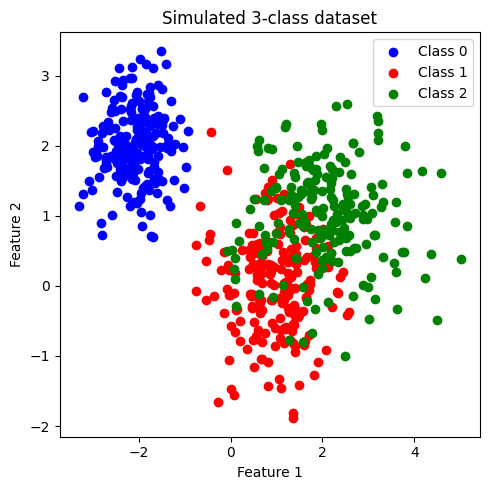

In [6]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]#[[-2,2], [0,0], [2,2]]
std_class  = [[0.5,0.5], [0.75,0.75],[1,0.75]]#[[1,0.75], [1,0.75],[1,0.75]] #[[0.75,0.5], [0.5,1],[0.5,0.75]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 200

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))
    
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()


### แบ่งข้อมูลเป็น train-test และ cross-validation
โดยไม่กำกับการแบ่งตามสัดส่วนคลาสของคำตอบ (stratification)

In [7]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    stratify=None, random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[  0. 169.]
 [  1. 155.]
 [  2. 156.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 31.]
 [ 1. 45.]
 [ 2. 44.]]


In [8]:
# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
#cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ SD จาก training set ในการ standardize test set เพื่อป้องกัน information leak

In [9]:
x_scaler = StandardScaler().fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       169
         1.0       0.82      0.85      0.83       155
         2.0       0.85      0.81      0.83       156

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.82      0.91      0.86        45
         2.0       0.90      0.80      0.84        44

    accuracy                           0.89       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.89      0.89      0.89       120



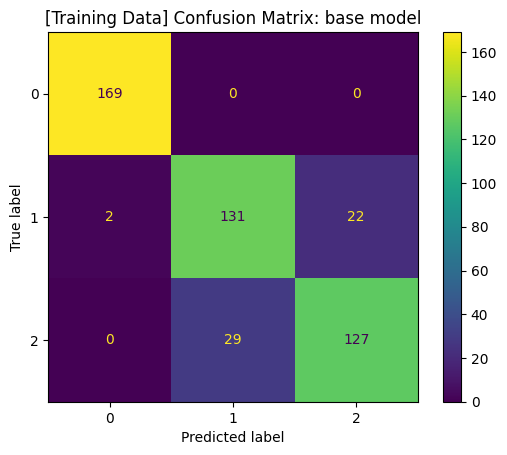

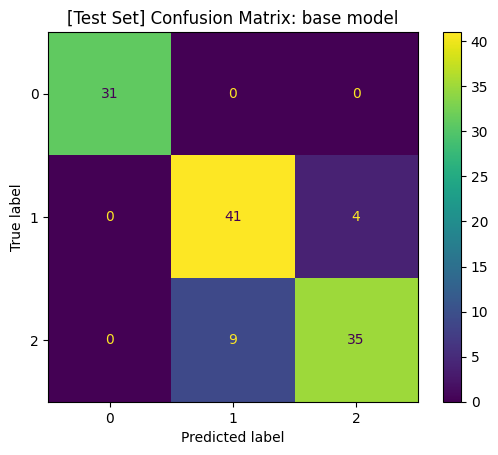

In [10]:
# สร้างโมเดล
base_clf = SVC(random_state=RANDOM_SEED)

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.title('[Training Data] Confusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.title('[Test Set] Confusion Matrix: base model')

plt.show()

### Hyperparameter tuning, then เทรนโมเดล ด้วย tuned model

We will tune 2 key hyperparameters:
1. 'kernel'
2. 'C' 



Training Set: Classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       169
         1.0       0.82      0.85      0.83       155
         2.0       0.85      0.81      0.83       156

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.82      0.91      0.86        45
         2.0       0.90      0.80      0.84        44

    accuracy                           0.89       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.89      0.89      0.89       120



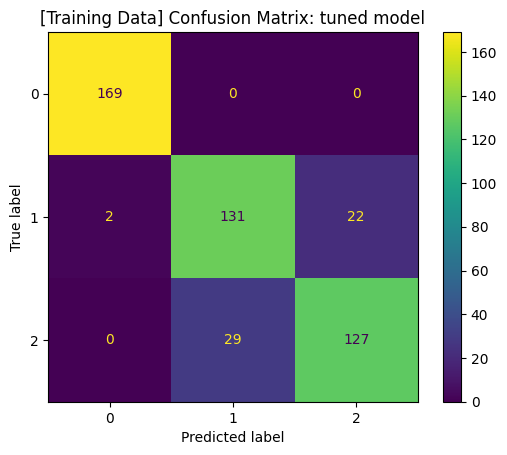

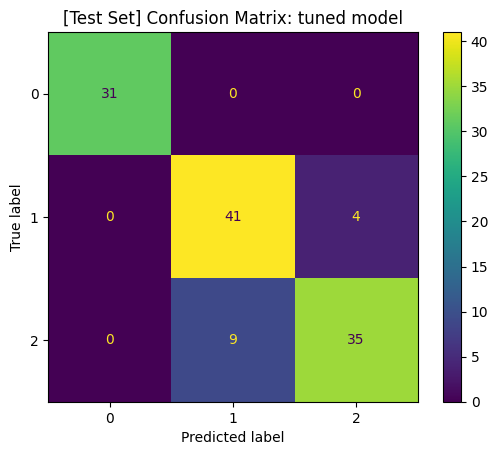

In [11]:
# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'kernel': ['rbf','linear'],
              'C': [0.01, 0.1, 1, 10, 100, 1000]
              }

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params 
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params, 
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.title('[Training Data] Confusion Matrix: tuned model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.title('[Test Set] Confusion Matrix: tuned model')

plt.show()

Result: Improve accuracy